These figures may differ slightly from the publication figures, because the random seed is different.

In [1]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
from deepcell_spots.simulate_data import sim_gt_clusters, sim_annotators, percent_correct
from deepcell_spots.cluster_vis import label_graph_gt, label_graph_prob
from deepcell_spots.spot_em import em_spot

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [2]:
num_trials = 50  # number of independent trials

tp_diff = []
fp_diff = []
for _ in tqdm(range(num_trials)):
    prior = 0.5  # probability that a simulated spot will be a TP spot
    num_clusters = 1000  # number of ground truth spots, ie clusters
    gt = sim_gt_clusters(num_clusters, prior)  # identity of spots as TP or FP

    num_classic_meth = 4  # number of simulated classical spot detection methods
    gt_tp_list = np.array([random.random() for i in range(num_classic_meth)])*0.2 + 0.8  # TPR of each sim. method
    gt_fp_list = np.array([random.random() for i in range(num_classic_meth)])*0.2  # FPR of each sim. method
    data = sim_annotators(gt, gt_tp_list, gt_fp_list)  # matrix of successful or missed detections

    tp_guess = [0.9] * num_classic_meth  # initial guess for TPR of each method
    fp_guess = [0.1] * num_classic_meth  # initial guess for FPR of each method
    prior_guess = 0.5  # prior probability of TP
    max_iter = 20  # number of EM iterations
    tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior_guess, max_iter)

    tp_diff.extend(np.array(tp_final) - gt_tp_list)  # error in estimate of TP
    fp_diff.extend(np.array(fp_final) - gt_fp_list)  # error in estimate of FP

100%|██████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.10it/s]


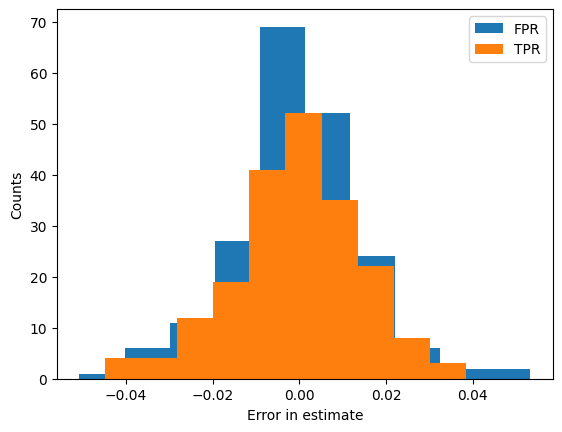

In [3]:
plt.hist(fp_diff, label='FPR')
plt.hist(tp_diff, label='TPR')
plt.legend()
plt.xlabel('Error in estimate')
plt.ylabel('Counts')
plt.show()

In [4]:
num_trials = 50  # number of independent trials per condition
num_sizes = 10  # number of conditions
data_set_size = np.logspace(1,4,num=num_sizes).astype(int)

p_correct_matrix = np.zeros((num_sizes,num_trials))

for i in tqdm(range(num_sizes)):
    for ii in range(num_trials):
        prior = 0.5  # probability that a simulated spot will be a TP spot
        gt = sim_gt_clusters(data_set_size[i],prior)  # identity of spots as TP or FP

        tp_list = np.array([random.random() for i in range(num_classic_meth)])*0.2 + 0.8  # TPR of each sim. method
        fp_list = np.array([random.random() for i in range(num_classic_meth)])*0.2  # FPR of each sim. method
        data = sim_annotators(gt, tp_list, fp_list)  # matrix of successful or missed detections

        tp_guess = [0.9] * num_classic_meth  # initial guess for TPR of each method
        fp_guess = [0.1] * num_classic_meth  # initial guess for FPR of each method

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)  # percent of spots correctly labeled

        p_correct_matrix[i,ii] = p_correct

100%|██████████████████████████████████████████████████████████████████| 10/10 [10:42<00:00, 64.20s/it]


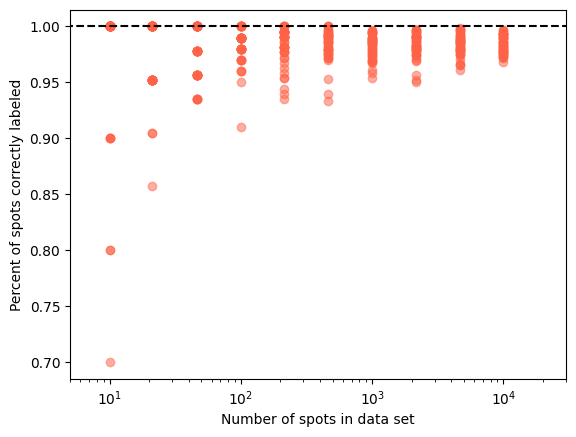

In [5]:
for i in range(num_sizes):
    plt.scatter([data_set_size[i]]*num_trials,p_correct_matrix[i],c='tomato',alpha=0.5)

plt.plot([0,10e4],[1,1],'k--')
plt.xscale('log')
plt.xlim((5,3e4))
plt.xlabel('Number of spots in data set')
plt.ylabel('Percent of spots correctly labeled')
plt.show()

In [6]:
num_trials = 50  # number of independent trials per condition
max_num_annotators = 13  # number of conditions

p_correct_matrix2 = np.zeros((max_num_annotators-2,num_trials))

for i in tqdm(range(2,max_num_annotators)):
    for ii in range(num_trials):
        prior = 0.5  # probability that a simulated spot will be a TP spot
        num_clusters = 1000  # number of ground truth spots, ie clusters
        gt = sim_gt_clusters(num_clusters, prior)  # identity of spots as TP or FP

        tp_list = np.array([random.random() for i in range(i)])*0.2 + 0.8  # TPR of each sim. method
        fp_list = np.array([random.random() for i in range(i)])*0.2  # FPR of each sim. method
        data = sim_annotators(gt, tp_list, fp_list)  # matrix of successful or missed detections

        tp_guess = [0.7]*i  # initial guess for TPR of each method
        fp_guess = [0.1]*i  # initial guess for FPR of each method

        tp_final, fp_final, p_matrix = em_spot(data, tp_guess, fp_guess, prior, 15)
        p_correct = percent_correct(gt, p_matrix)  # percent of spots correctly labeled

        p_correct_matrix2[i-2,ii] = p_correct

100%|██████████████████████████████████████████████████████████████████| 11/11 [07:43<00:00, 42.17s/it]


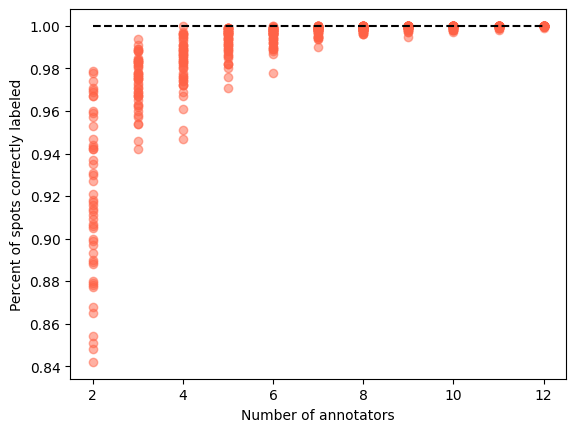

In [7]:
for i in range(np.shape(p_correct_matrix2)[0]):
    if i == 0:
        plt.scatter([i+2]*num_trials,p_correct_matrix2[i],c='tomato',alpha=0.5,label='Random TP-wide')
    else:
        plt.scatter([i+2]*num_trials,p_correct_matrix2[i],c='tomato',alpha=0.5)
        
plt.plot([2,12],[1,1],'k--')
plt.xlabel('Number of annotators')
plt.ylabel('Percent of spots correctly labeled')
plt.show()

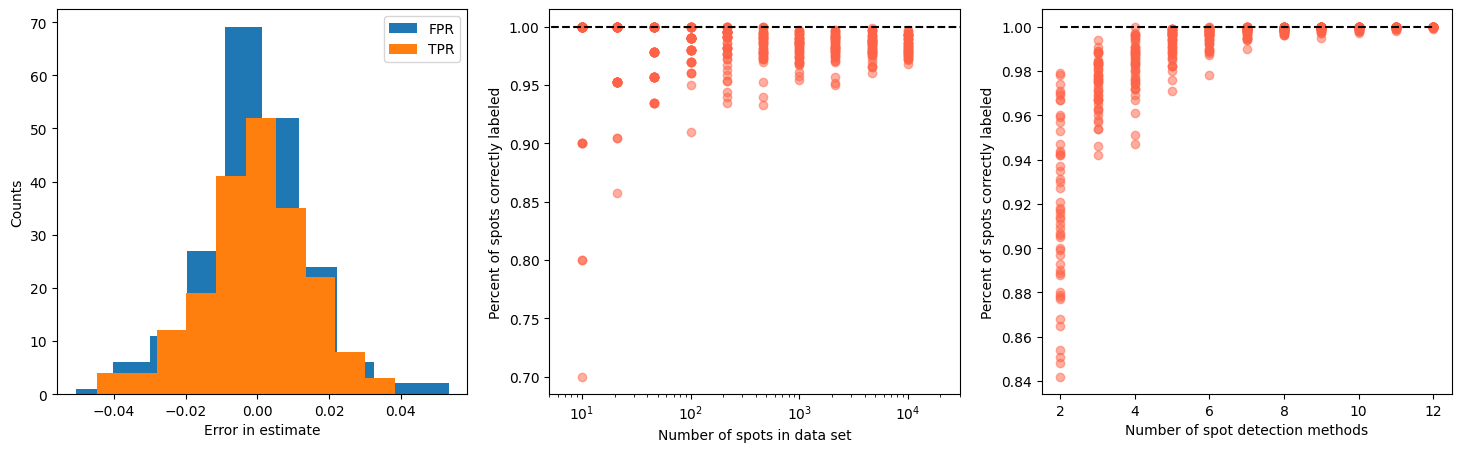

In [8]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].hist(fp_diff, label='FPR')
ax[0].hist(tp_diff, label='TPR')
ax[0].legend()
ax[0].set_xlabel('Error in estimate')
ax[0].set_ylabel('Counts')

for i in range(num_sizes):
    ax[1].scatter([data_set_size[i]]*num_trials,p_correct_matrix[i],c='tomato',alpha=0.5)

ax[1].plot([0,10e4],[1,1],'k--')
ax[1].set_xscale('log')
ax[1].set_xlim((5,3e4))
ax[1].set_xlabel('Number of spots in data set')
ax[1].set_ylabel('Percent of spots correctly labeled')

for i in range(np.shape(p_correct_matrix2)[0]):
        ax[2].scatter([i+2]*num_trials,p_correct_matrix2[i],c='tomato',alpha=0.5)
        
ax[2].plot([2,12],[1,1],'k--')
ax[2].set_xlabel('Number of spot detection methods')
ax[2].set_ylabel('Percent of spots correctly labeled')

plt.show()